<a href="https://colab.research.google.com/github/Ajay303/riceplant_diseases_detection/blob/master/cnn_for_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/Ajay303/riceplant_diseases_detection.git

Cloning into 'riceplant_diseases_detection'...
remote: Enumerating objects: 3366, done.
remote: Counting objects: 100% (3366/3366), done.
remote: Compressing objects: 100% (3364/3364), done.
remote: Total 3366 (delta 2), reused 3362 (delta 1), pack-reused 0
Receiving objects: 100% (3366/3366), 2.80 MiB | 4.94 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [7]:
cd riceplant_diseases_detection

/content/riceplant_diseases_detection


In [8]:
ls

README.md  Resized_Labelled/  Test/


In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm
import random
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.


In [0]:
PATH = os.getcwd()
#DATADIR = PATH + '/dhrcdata/Train'		
train_data_path = PATH + '/Resized_Labelled'
test_data_path = PATH + '/Test'


In [11]:
#counting categories
new_cat = []
for x in os.listdir(train_data_path):
  new_cat.append(x)

print(new_cat)  
classes = np.unique(new_cat)
print(len(classes))


['BrownSpot', 'Healthy', 'LeafBlast', 'Hispa']
4


In [0]:
CATEGORIES = [

"Healthy","Hispa","LeafBlast","BrownSpot"
]



In [0]:
IMG_SIZE = 128
training_data = []
testing_data = []

def create_training_data():
  for catagory in CATEGORIES:
    path = os.path.join(train_data_path, catagory)
    class_num = CATEGORIES.index(catagory)
    for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
          training_data.append([new_array,class_num])
        except Exception as e:
          pass



def create_testing_data():
  for catagory in CATEGORIES:
    path = os.path.join(test_data_path, catagory)
    class_num = CATEGORIES.index(catagory)
    for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
          testing_data.append([new_array,class_num])
        except Exception as e:
          pass



create_training_data()
create_testing_data()


In [15]:
#shuffle training data for trainning diff image set in every batch
random.shuffle(training_data)

#hot encode image dataset

train_x = []
train_y = []
test_x = []
test_y = []



#seperating features and labels from list
for features, labels in training_data:
	train_x.append(features)
	train_y.append(labels)

for features, labels in testing_data:
	test_x.append(features)
	test_y.append(labels)


#converting list to array
train_y_array = np.array(train_y)
test_y_array = np.array(test_y)

#converting image dataset to input 32*32 dataset 

train_image_array = np.array(train_x).reshape(-1,32,32,1)
test_image_array = np.array(test_x).reshape(-1,32,32,1)

#counting total number of class in dataset
classes = np.unique(test_y_array)
print(classes)
print("total number of class={} ".format(len(classes)))



[0 1 2 3]
total number of class=4 


In [16]:
train_image_array.shape

(3354, 32, 32, 1)

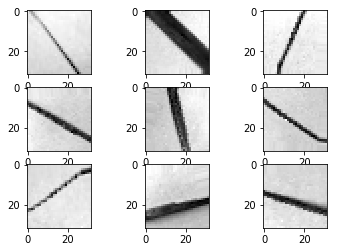

In [17]:
# convert from int to float
x_train = train_image_array.astype('float32')
x_test = test_image_array.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                              zoom_range=0.2
                            )
# fit parameters from data
datagen.fit(x_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, train_y, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

In [0]:

#one hot enoded class 
train_y = to_categorical(train_y_array)
test_y = to_categorical(test_y_array)


train_y = np.array(train_y)
test_y = np.array(test_y)

#all train x, y and test x y are in array form now


In [21]:
train_image_array.shape

(3354, 32, 32, 1)

In [23]:
#new model

# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

# Define the optimizer
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=0.0001)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#model.summary()

history = model.fit(x=train_image_array,y=train_y,epochs=20,batch_size=100, validation_split=0.3)

Instructions for updating:
Use tf.cast instead.
Train on 2347 samples, validate on 1007 samples
Epoch 1/20
2347/2347 [==============================] - 7s 3ms/step - loss: 9.1463 - acc: 0.4082 - val_loss: 8.2428 - val_acc: 0.4836
Epoch 2/20
2347/2347 [==============================] - 0s 148us/step - loss: 9.2272 - acc: 0.4073 - val_loss: 8.3231 - val_acc: 0.4836
Epoch 3/20
2347/2347 [==============================] - 0s 151us/step - loss: 8.9288 - acc: 0.3669 - val_loss: 7.6892 - val_acc: 0.4836
Epoch 4/20
2347/2347 [==============================] - 0s 151us/step - loss: 8.2562 - acc: 0.3677 - val_loss: 3.6848 - val_acc: 0.3684
Epoch 5/20
2347/2347 [==============================] - 0s 152us/step - loss: 2.4168 - acc: 0.3200 - val_loss: 1.2610 - val_acc: 0.4826
Epoch 6/20
2347/2347 [==============================] - 0s 146us/step - loss: 1.3783 - acc: 0.3754 - val_loss: 1.2880 - val_acc: 0.4727
Epoch 7/20
2347/2347 [==============================] - 0s 149us/step - loss: 1.3384 - acc

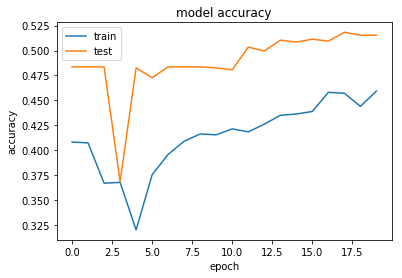

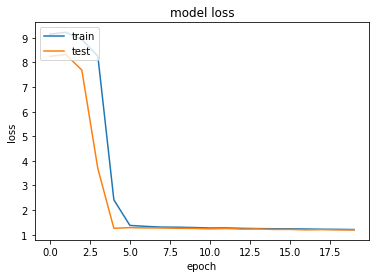

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
img = train_x[1603].reshape(-1,32,32,1)
belongs_to_class = train_y[1603]

In [46]:
print(img.shape)

(1, 32, 32, 1)


In [0]:
x = model.predict(img)

In [48]:
print(x)

[[0.3575553  0.17725827 0.28979546 0.175391  ]]


In [0]:
name = CATEGORIES[np.argmax(x)]
bc = CATEGORIES[np.argmax(belongs_to_class)]

predicted image is of: Healthy
Actual class label is: [1. 0. 0. 0.]


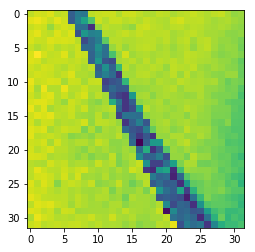

In [51]:
%matplotlib inline

print("predicted image is of: {}".format(name))
print("Actual class label is: {}".format(test_y[0]))
imgplot = plt.imshow(test_x[1603])

